In [2]:
# Packages are imported.
import pandas as pd
import requests as req
import numpy as np
import datetime as dt
import time
import multiprocessing as mp
import os
import random
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.stats.multitest as statsmodels
import pickle
np.random.seed(1)

In [ ]:
sys.setrecursionlimit(25000)

# Data Extracting

In [ ]:
# Function that requests data. Change IP to external IP of one of the VM's collecting data.
def request_data(job, startTime, endTime):
    
    print('Job request: ' + str(job) + ' started.')
    #print(startTime)
    #print(job)
    #print(endTime)
    request = req.get('http://35.246.188.180:30000/api/v1/query_range?query={job=~"' + job + '"}&start=' + startTime + 'Z&end=' + endTime + 'Z&step=1s')
    #print(eval(request.content))
    metric_data = pd.DataFrame(eval(request.content))
    
    return metric_data

In [ ]:
# Change IP to external IP of one of the VM's collecting data.
def get_jobs():
    # Cluster: Get list of jobs
    x = req.get('http://35.246.188.180:30000/api/v1/label/job/values')
    jobList = eval(x.content)['data']
    
    return jobList

# Get timestamps for next 15mins.
def get_timestamps(date):
    
    scrape_timeframes = []
    interval = dt.timedelta(minutes=14, seconds=59)

    scrape_timeframes.append([str(date).replace(" ", "T"), str(date + interval).replace(" ", "T"), pd.date_range(date, (date + interval), freq='1S')])
   
    return scrape_timeframes

# Info of features is saved in separate files.
def save_feature_info(job, dfList_info):
    
    dfFeatures_info = pd.concat(dfList_info, axis=1)
    dfFeatures_info.columns = [str(column) + dfFeatures_info.columns[column] for column in range(0, len(dfFeatures_info.columns))]
    list_features_info = [dirs for dirs in os.listdir('data_scraped/feature_info/') if job in dirs]
    file_number = len(list_features_info) + 1
    dfFeatures_info.to_feather('data_scraped/feature_info/features_' + job + str(file_number) + '.ftr')

# Function to load in data and structure it into one dataframe.
def structureData(job, date):
    
    scrape_timeframes = get_timestamps(date)
    features_dict = {'Timestamp' : scrape_timeframes[0][2]}

    dfMetric = request_data(job, scrape_timeframes[0][0], scrape_timeframes[0][1])
    dfFeatures = pd.DataFrame(features_dict)
    
    print(job + ' metrics: ' + str(len(dfMetric['data'][0])))
    
    dfList = [pd.DataFrame(metric['values'], columns=['Timestamp', '#'.join(list(metric['metric'].values()))]) for metric in dfMetric['data'][0]]
    dfList_info = [pd.DataFrame(metric['metric'].keys(), columns=['#'.join(list(metric['metric'].keys()))]) for metric in dfMetric['data'][0]]
    dfList.insert(0, dfFeatures)
    
    for df in dfList:
        if len(df.columns) > 1:
            df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
            
        else:
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    dfList = [df.set_index('Timestamp', drop=True) for df in dfList]
    
    
    save_feature_info(job, dfList_info)
    
    dfFeatures = pd.concat(dfList, axis=1)
        
        
    
    print('Done: ' + job)
    return dfFeatures

In [ ]:
# Function that saves the data as feather files.
def save_data(job, date):
    tic = time.clock()
    df = structureData(job, date)
    file_number = len(os.listdir('data_scraped/' + job + '/')) + 1
    df.reset_index(inplace=True)
    
    df.to_feather('data_scraped/' + job + '/' + job + str(file_number - 1) + '.ftr')
    toc = time.clock()
    print(job + ': ' + str(toc-tic))
    
    return df


In [ ]:
# For each separate job, data is requested in a timeframe of 15mins, structured, and then saved.
job_list = ['envoy-stats', 'istiod', 'kube-state-metrics', 'kubernetes-apiservers', 'kubernetes-cadvisor', 'kubernetes-nodes', 'kubernetes-pods', 'kubernetes-service-endpoints', 'litmuschaos', 'skydive']
def scrape_data(job_list):
    dfDates = pd.date_range('11:00', '15:45', freq='15min')
    interval = dt.timedelta(minutes=15, seconds=1)
    now = dt.datetime.now()
    
    
    for date in dfDates:
        time_passed = False
    
        while time_passed is False:
    
            if now > (date + interval):
            
                time_passed = True
    
    
                for job in job_list:
    
                    df = save_data(job, date)
                    time.sleep(5)    
    
            else:
                print('Too early')
                time.sleep(60)
    
            now = dt.datetime.now()

In [ ]:
# The function to collect data is run.
scrape_data(job_list)

# Data preparation

The collected data is filtered. Litmus related and constant features are removed along with features containing too many missing values. 

In [32]:
# Litmus related features are removed.
def filter_chaos(dataset):

    filter_keywords_list = ['litmus', 'litmuschaos', 'chaos', 'chaos-runner', 'hog', 'iostress', 'helper'] 
    column_list = []
    iteration_list = []
    final_feature_list = []
    checked_shape = False
    dataframes_list = []
    
    df = pd.read_feather(dataset)

    for column in df.columns:
        if any(keyword in column for keyword in filter_keywords_list) == False:
            iteration_list.append(column)
    
    return iteration_list

In [33]:
# Function to convert datatypes to numeric.
def convert_datatype(column_data):

    return column_data[0][column_data[1]].apply(pd.to_numeric, errors='coerce')   

In [34]:
# Parallelization function.
def modifyParallelized(function, df):
  
    
    column_list = [[df, column] for column in df.columns]
    
    # All the available cores are used.
    cores=mp.cpu_count()

    # Create the multiprocessing pool of cores.
    pool = mp.Pool(cores)
    
 
    columns_converted = pool.map(function, column_list)
    

    # Close down the pool and join.
    pool.close()
    pool.join()
    #pool.clear()
    
    return columns_converted

In [38]:
# Scraped data for jobs are read, combined, filtered, and saved to pickle files. 
job_list = ['envoy-stats', 'istiod', 'kube-state-metrics', 'kubernetes-apiservers', 'kubernetes-cadvisor', 'kubernetes-nodes', 'kubernetes-pods', 'kubernetes-service-endpoints', 'litmuschaos', 'skydive']
filter_keywords_list = ['litmus', 'litmuschaos', 'chaos', 'chaos-runner', 'hog', 'iostress', 'helper'] 

for job in job_list:
    
    if os.path.isfile('data_combined_filtered/' + job + '/' + job + '_filtered.pkl') == True:
        continue
    
    column_list = []
    iteration_list = []
    final_feature_list = []
    dataframes_list = []
    
    # Paths for each file are generated.
    dataset_dirs = ['data_scraped/' + job + '/' + file for file in os.listdir('data_scraped/' + job) if job in file]
    dataset_dirs.sort()
    
    print('Start Job: ' + job)
    
    df = pd.read_feather(dataset_dirs[0])
    
    print(df.shape)
    
    # Any non-litmus job is filtered on litmus related features.
    if job != 'litmuschaos':
        column_list = filter_chaos(dataset_dirs[0])
        df = df[column_list]
    
    # NA's are dropped, features having more than 5 NA's are dropped.
    df.dropna(axis=1, inplace=True, thresh=(len(df) - 5))
    print(df.shape)
    column_list = [column for column in df.columns if "Timestamp" not in column]
    df[column_list] = pd.concat(modifyParallelized(convert_datatype, df[column_list]), axis=1)
    
  
    print(df.shape)
    
    df.dropna(axis=1, inplace=True, thresh=(len(df) - 5))
    
    
    column_list = df.columns
    df.set_index('Timestamp', drop=True, inplace=True)
    
    # All datasets are merged into one dataset.
    for dataset in dataset_dirs[1:]:
        print(dataset)
        df_concat = pd.read_feather(dataset).set_index('Timestamp', drop=True)
        concat_columns = list(set(column_list).intersection(df_concat.columns))
        df_concat = pd.concat(modifyParallelized(convert_datatype, df_concat[concat_columns]), axis=1)
        
        df = pd.concat([df, df_concat[concat_columns]], axis=0)
        time.sleep(2)
    
    
    print(df.shape)
    
    # For litmuschaos, only features showing which experiment is running are kept.
    if job == 'litmuschaos':
        
        df.dropna(axis=0, inplace=True)
        df = df[[column for column in df.columns if 'awaited_experiments' in column]]
    
    # Final filters are executed.
    else:
        column_list = filter_chaos(dataset_dirs[0])
        df.reset_index(drop=False, inplace=True)
        df.dropna(axis=1, inplace=True, thresh=(len(df) - 5))
        df.dropna(axis=0, inplace=True)
        df = df.loc[:, (df != df.iloc[0]).any()]
        
    
    print(df.shape)
    
    df.to_pickle('data_combined_filtered/' + job + '/' + job + '_filtered.pkl')

Start Job: litmuschaos
(900, 199)
(900, 119)
(900, 119)
data_scraped/litmuschaos/litmuschaos10.ftr
data_scraped/litmuschaos/litmuschaos11.ftr
data_scraped/litmuschaos/litmuschaos12.ftr
data_scraped/litmuschaos/litmuschaos13.ftr
data_scraped/litmuschaos/litmuschaos14.ftr
data_scraped/litmuschaos/litmuschaos15.ftr
data_scraped/litmuschaos/litmuschaos16.ftr
data_scraped/litmuschaos/litmuschaos17.ftr
data_scraped/litmuschaos/litmuschaos18.ftr
data_scraped/litmuschaos/litmuschaos19.ftr
data_scraped/litmuschaos/litmuschaos2.ftr
data_scraped/litmuschaos/litmuschaos20.ftr
data_scraped/litmuschaos/litmuschaos21.ftr
data_scraped/litmuschaos/litmuschaos22.ftr
data_scraped/litmuschaos/litmuschaos23.ftr
data_scraped/litmuschaos/litmuschaos24.ftr
data_scraped/litmuschaos/litmuschaos25.ftr
data_scraped/litmuschaos/litmuschaos26.ftr
data_scraped/litmuschaos/litmuschaos27.ftr
data_scraped/litmuschaos/litmuschaos28.ftr
data_scraped/litmuschaos/litmuschaos29.ftr
data_scraped/litmuschaos/litmuschaos3.ftr


In [9]:
# Feature summary of all jobs. 
for job in job_list:
    df = pd.read_pickle('data_combined_filtered/' + job + '/' + job + '_filtered.pkl')
    print(job)
    print(df.shape)

envoy-stats
(26096, 1845)
istiod
(26100, 148)
kube-state-metrics
(26100, 73)
kubernetes-apiservers
(26100, 6)
kubernetes-cadvisor
(26092, 3205)
kubernetes-nodes
(26090, 1467)
kubernetes-pods
(26095, 2390)
kubernetes-service-endpoints
(26095, 2386)
litmuschaos
(26099, 7)
skydive
(26100, 6)


In [25]:
# Metrics are generated for each dataset based on a 45 second sliding window. They are also saved.
def generate_metrics(job):
    
    df = pd.read_pickle('data_combined_filtered/' + job + '/' + job + '_filtered.pkl').set_index('Timestamp', drop=True).sort_values(by='Timestamp')
    
    dfMetric = df.rolling('45s').mean()
    dfMetric.columns = ['mean_' + column for column in dfMetric.columns]
    dfMetric.to_pickle('metrics/' + job + '/' + '_mean_' + job + '.pkl')
    
    dfMetric = df.rolling('45s').quantile(0.05)
    dfMetric.columns = ['quantile05_' + column for column in dfMetric.columns]
    dfMetric.to_pickle('metrics/' + job + '/' + '_quantile05_' + job + '.pkl')
    
    dfMetric = df.rolling('45s').quantile(0.25)
    dfMetric.columns = ['quantile25_' + column for column in dfMetric.columns]
    dfMetric.to_pickle('metrics/' + job + '/' + '_quantile25_' + job + '.pkl')

    dfMetric = df.rolling('45s').quantile(0.50)
    dfMetric.columns = ['quantile50_' + column for column in dfMetric.columns]
    dfMetric.to_pickle('metrics/' + job + '/' + '_quantile50_' + job + '.pkl')
    
    dfMetric = df.rolling('45s').quantile(0.75)
    dfMetric.columns = ['quantile75_' + column for column in dfMetric.columns]
    dfMetric.to_pickle('metrics/' + job + '/' + '_quantile75_' + job + '.pkl')
    
    dfMetric = df.rolling('45s').quantile(0.95)
    dfMetric.columns = ['quantile95_' + column for column in dfMetric.columns]
    dfMetric.to_pickle('metrics/' + job + '/' + '_quantile95_' + job + '.pkl')
    
    dfMetric = df.rolling('45s').var()
    dfMetric.columns = ['variance_' + column for column in dfMetric.columns]
    dfMetric.to_pickle('metrics/' + job + '/' + '_variance_' + job + '.pkl')
    
    dfMetric = df.rolling('45s').skew()
    dfMetric.columns = ['skewness_' + column for column in dfMetric.columns]
    dfMetric.to_pickle('metrics/' + job + '/' + '_skewness_' + job + '.pkl')
    
    dfMetric = df.rolling('45s').min()
    dfMetric.columns = ['minimum_' + column for column in dfMetric.columns]
    dfMetric.to_pickle('metrics/' + job + '/' + '_minimum_' + job + '.pkl')
    
    dfMetric = df.rolling('45s').max()
    dfMetric.columns = ['maximum_' + column for column in dfMetric.columns]
    dfMetric.to_pickle('metrics/' + job + '/' + '_maximum_' + job + '.pkl')
    
    dfMetric = df.rolling('45s').kurt()
    dfMetric.columns = ['kurtosis_' + column for column in dfMetric.columns]
    dfMetric.to_pickle('metrics/' + job + '/' + '_kurtosis_' + job + '.pkl')
    
    return job + ' Done'

def generateParallelized(function, job_list):
  
    # All the available cores are used.
    cores=mp.cpu_count()

    # Create the multiprocessing pool of cores.
    pool = mp.Pool(cores)
    
 
    columns_converted = pool.map(function, job_list)
    

    # Close down the pool and join.
    pool.close()
    pool.join()
    #pool.clear()
    
    return columns_converted    


In [ ]:
# Metrics are generated for each dataset.
generateParallelized(generate_metrics, [job for job in job_list if job != 'litmuschaos'])

In [32]:
# Rated features are also saved.
df = pd.DataFrame()
for job in [job for job in job_list if job != 'litmuschaos']:
    df_new = pd.read_pickle('data_combined_filtered/' + job + '/' + job + '_filtered.pkl').set_index('Timestamp', drop=True)
    df = pd.concat([df, df_new[[column for column in df_new.columns if 'total' in column]]], axis=1)
    print(job)
    print(df_new.shape)

df.sort_values(by='Timestamp', inplace=True)
df.columns = ['rated_' + column for column in df.columns]
df = df.diff()
df.reset_index(drop=False, inplace=True)
df.to_pickle('data_combined_filtered/totals-rated/totals-rated_filtered.pkl')

In [33]:
# Metrics are generated for the rated metrics.
generateParallelized(generate_metrics, ['totals-rated'])

In [ ]:
# Read litmus data
df = pd.read_pickle('data_combined_filtered/litmuschaos/litmuschaos_filtered.pkl')

In [43]:
# Rename litmus features to right experiment names. 

new_names_dict = {'litmuschaos_awaited_experiments#teastore-chaos#teastore-chaos-node-cpu-hog#default#35.246.222.195:31111#litmuschaos' : 'Node CPU hog',
                 'litmuschaos_awaited_experiments#teastore-chaos#teastore-chaos-node-io-stress#default#35.246.222.195:31111#litmuschaos' : 'Node IO stress',
                 'litmuschaos_awaited_experiments#teastore-chaos#teastore-chaos-node-memory-hog#default#35.246.222.195:31111#litmuschaos' : 'Node memory hog',
                 'litmuschaos_awaited_experiments#teastore-chaos#teastore-chaos-pod-cpu-hog#default#35.246.222.195:31111#litmuschaos' : 'Pod CPU hog',
                 'litmuschaos_awaited_experiments#teastore-chaos#teastore-chaos-pod-io-stress#default#35.246.222.195:31111#litmuschaos' : 'Pod IO stress',
                 'litmuschaos_awaited_experiments#teastore-chaos#teastore-chaos-pod-memory-hog#default#35.246.222.195:31111#litmuschaos' : 'Pod memory hog',
                 'litmuschaos_namespace_scoped_awaited_experiments#default#35.246.222.195:31111#litmuschaos' : 'Anomalous'}

df.rename(columns=new_names_dict, inplace=True)


In [44]:
# All experiments are combined into one multi-class feature. 
conditions = [
    (df['Node CPU hog'] == 1),
    (df['Node IO stress'] == 1),
    (df['Node memory hog'] == 1),
    (df['Pod CPU hog'] == 1),
    (df['Pod IO stress'] == 1),
    (df['Pod memory hog'] == 1),
    (df['Anomalous'] == 0)]

options = ['Node CPU hog', 'Node IO stress', 'Node memory hog', 'Pod CPU hog', 'Pod IO stress', 'Pod memory hog', 'Non-anomalous']
options_numbers = [0, 1, 2, 3, 4, 5, 6]
df['Anomaly_name'] = np.select(conditions, options)
df['Anomaly_nr'] = np.select(conditions, options_numbers)


In [46]:
# The changes are saved into a new file.
df.to_pickle('finalLitmus/litmusfinal.pkl')

# Feature Selection

In [38]:
# Function to calculate p-value for given columns in a df.
def calcPValue(df, column):
    
    pvalue = stats.ks_2samp(df.loc[df['Anomalous']==0, column].values.tolist(), df.loc[df['Anomalous']==1, column].values.tolist())[1]
    
    return pvalue

feature_pvalues = []
job_list = ['envoy-stats', 'istiod', 'kube-state-metrics', 'kubernetes-apiservers', 'kubernetes-cadvisor', 'kubernetes-nodes', 'kubernetes-pods', 'kubernetes-service-endpoints', 'totals-rated', 'skydive']
folders = ['data_combined_filtered/', 'metrics/']

In [39]:
# Get paths of files.
def getFilePaths():
    
    
    directories = []
    
    
    for root, dirs, files in os.walk('metrics/', topdown=False):
        for name in files:
                
            if ('ipynb' not in name) and ('litmus' not in name):
                    
                directories.append(os.path.join(root, name))
        
    return directories

In [40]:
def calc_p_value(directory):
    
    
    dfFeatures = pd.DataFrame(columns=['Feature', 'p_value'])
    df_litmus = pd.read_pickle('finalLitmus/litmusfinal.pkl')
    if 'data_combined_filtered' in directory:
        df_metric = pd.read_pickle(directory).set_index('Timestamp', drop=True)
    else:
        df_metric = pd.read_pickle(directory)
    
    df_metric = pd.concat([df_metric, df_litmus['Anomalous']], axis=1)
    df_metric.dropna(axis=1, inplace=True, thresh=(len(df_metric) - 20))
    df_metric.dropna(axis=0, inplace=True)
    
    dfFeatures = pd.DataFrame([(column, calcPValue(df_metric, column)) for column in df_metric.columns if ((column != 'anomaly') and (column != 'time') and (column != 'Anomalous'))], columns = ['Feature', 'p_value'])
    
    return dfFeatures

In [41]:
# Parallelization of p-value calculation.
def pvalue_parallelized(function, directories):
  
    # All the available cores are used.
    cores=mp.cpu_count()

    # Create the multiprocessing pool of cores.
    pool = mp.Pool(cores)
    
 
    #Schrijf hier vstack en pd.df
    feature_list = pd.DataFrame(np.vstack(pool.map(function, directories)), columns=['Features', 'P_value'])
    

    # Close down the pool and join.
    pool.close()
    pool.join()
    #pool.clear()
    
    return feature_list

In [7]:
df_pvalue = pvalue_parallelized(calc_p_value, getFilePaths())

In [8]:
df_pvalue.sort_values(by='P_value')

,Features,P_value
75994,quantile25_node_filesystem_files_free#/dev/sda...,0
77345,quantile25_prometheus_sd_discovered_targets#ku...,0
85583,quantile95_node_filesystem_files_free#/dev/sda...,0
85582,quantile95_node_filesystem_files_free#/dev/sda...,0
77568,quantile25_scrape_samples_post_metric_relabeli...,0
...,...,...
38607,quantile05_rated_container_fs_reads_total#amd6...,1
38606,quantile05_rated_container_fs_reads_total#amd6...,1
38605,quantile05_rated_container_fs_reads_total#amd6...,1
38616,quantile05_rated_container_fs_reads_total#amd6...,1


In [9]:
# P-values are saved.
df_pvalue.to_pickle('feature selection/pvalues_onlymetrics.pkl')

In [6]:
# Function for feature selection.
def select_features(alpha):
    df_pvalue = pd.read_pickle('feature selection/pvalues_onlymetrics.pkl')
    by_results = statsmodels.multipletests(df_pvalue['P_value'], alpha=alpha, method='fdr_by')
    df_pvalue['Rejected'] = by_results[0]
    df_pvalue['P_vals_corrected'] = by_results[1]
    df_filtered = df_pvalue.loc[df_pvalue.Rejected==True]
    
    return df_filtered

In [34]:
# Features are selected.
df = select_features(0.000000000000000000000000000000000000001)

# Data Analysis

In [75]:
pd.read_pickle('finalLitmus/litmusfinal.pkl')

,Node CPU hog,Node IO stress,Node memory hog,Pod CPU hog,Pod IO stress,Pod memory hog,Anomalous,Anomaly_name,Anomaly_nr
Timestamp,,,,,,,,,
2021-07-27 18:17:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non-anomalous,6
2021-07-27 18:17:01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non-anomalous,6
2021-07-27 18:17:02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non-anomalous,6
2021-07-27 18:17:03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non-anomalous,6
2021-07-27 18:17:04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non-anomalous,6
...,...,...,...,...,...,...,...,...,...
2021-07-27 20:31:55,0.0,0.0,0.0,0.0,1.0,0.0,1.0,Pod IO stress,4
2021-07-27 20:31:56,0.0,0.0,0.0,0.0,1.0,0.0,1.0,Pod IO stress,4
2021-07-27 20:31:57,0.0,0.0,0.0,0.0,1.0,0.0,1.0,Pod IO stress,4


In [2]:
# Barplot dataframe
df = pd.read_pickle('finalLitmus/litmusfinal.pkl')
barplot = df.groupby(['Anomaly_name'], as_index=False).count()
barplot = barplot[['Anomaly_name', 'Node CPU hog']][1:]

In [20]:
barplot['Anomaly_name']

1       Node CPU hog
2     Node IO stress
3    Node memory hog
4      Non-anomalous
5        Pod CPU hog
6      Pod IO stress
7     Pod memory hog
Name: Anomaly_name, dtype: object

In [3]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.figure(figsize=(8,4), tight_layout=True)
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

<Figure size 576x288 with 0 Axes>

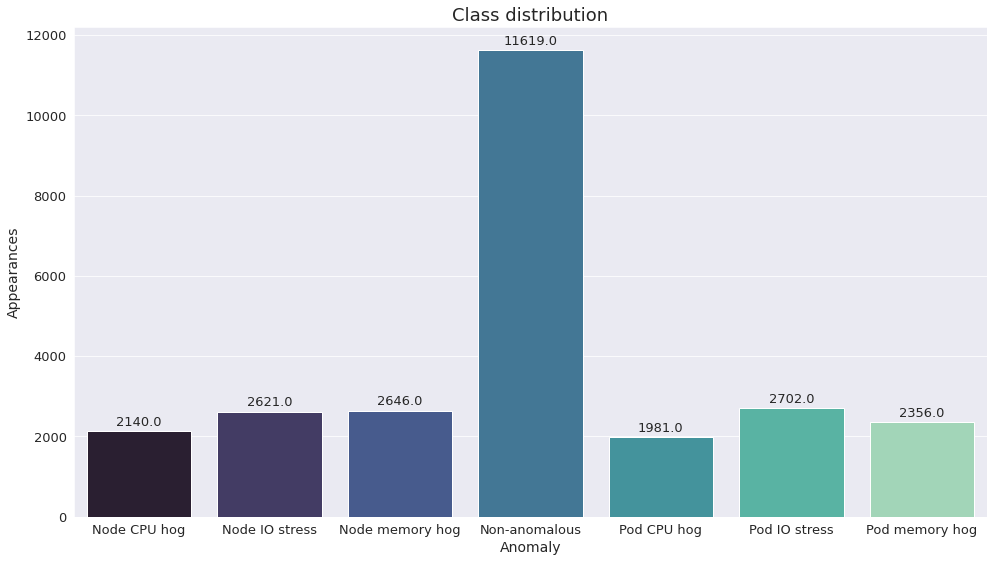

In [4]:
# Show class imbalance.
np.random.seed(1)
plt.figure(figsize=(14,8), tight_layout=True)
ax = sns.barplot(x=barplot['Anomaly_name'], y=barplot['Node CPU hog'], palette='mako', ci=None)
ax.set(title='Class distribution', xlabel='Anomaly', ylabel='Appearances')


for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.show()

# Pre-processing

In [14]:
df.reset_index(inplace=True)

In [12]:
df_final = pd.read_pickle('finalLitmus/litmusfinal.pkl')
df_final

,Node CPU hog,Node IO stress,Node memory hog,Pod CPU hog,Pod IO stress,Pod memory hog,Anomalous,Anomaly_name,Anomaly_nr
Timestamp,,,,,,,,,
2021-07-27 18:17:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non-anomalous,6
2021-07-27 18:17:01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non-anomalous,6
2021-07-27 18:17:02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non-anomalous,6
2021-07-27 18:17:03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non-anomalous,6
2021-07-27 18:17:04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non-anomalous,6
...,...,...,...,...,...,...,...,...,...
2021-07-27 20:31:55,0.0,0.0,0.0,0.0,1.0,0.0,1.0,Pod IO stress,4
2021-07-27 20:31:56,0.0,0.0,0.0,0.0,1.0,0.0,1.0,Pod IO stress,4
2021-07-27 20:31:57,0.0,0.0,0.0,0.0,1.0,0.0,1.0,Pod IO stress,4


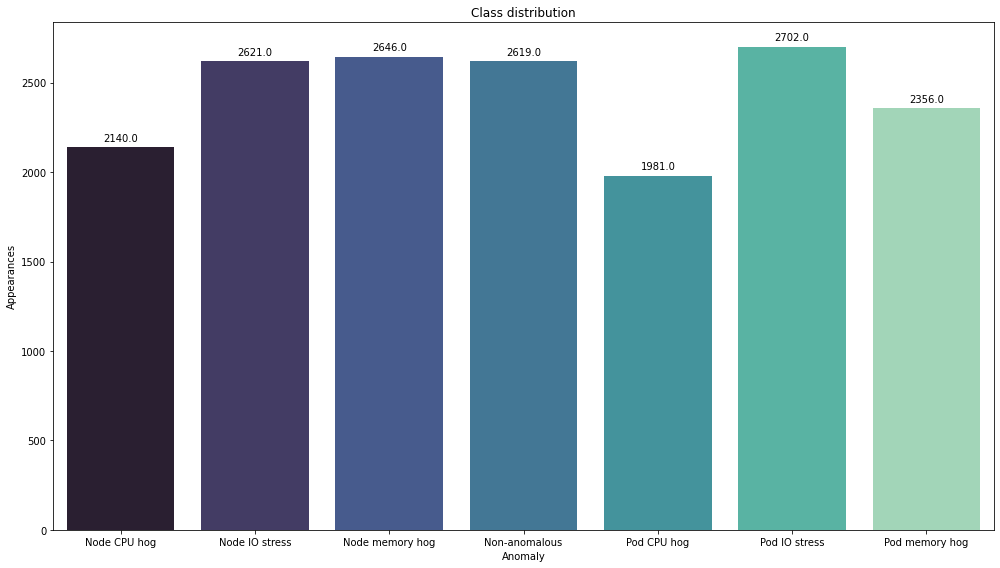

In [3]:
# Remove 9000 random non-anomalous instances. Show new distribution
df_final = pd.read_pickle('finalLitmus/litmusfinal.pkl')
df_final = df_final[~df_final.index.isin(random.sample(list(df_final[df_final['Anomaly_name']=='Non-anomalous'].index), k=9000))]
barplot = df_final.groupby(['Anomaly_name'], as_index=False).count()
barplot = barplot[['Anomaly_name', 'Node CPU hog']][1:]

plt.figure(figsize=(14,8), tight_layout=True)
ax = sns.barplot(x=barplot['Anomaly_name'], y=barplot['Node CPU hog'], palette='mako', ci=None)
ax.set(title='Class distribution', xlabel='Anomaly', ylabel='Appearances')


for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.show()

In [120]:
# All feature selection in 1.
directories = getFilePaths()
df = pd.read_pickle('finalLitmus/litmusfinal.pkl')

df_selection = select_features(0.000000000000000000000000000000000000001)
df_selection.to_pickle('feature selection/features_selected7.pkl')

df_processed = df[~df.index.isin(random.sample(list(df[df['Anomaly_name']=='Non-anomalous'].index), k=9000))]
column_list = df_selection['Features']

for file in directories:
    print(file)
    df_new = pd.read_pickle(file)
    if file[:4] == 'data':
          df_new.set_index('Timestamp', inplace=True)
           
    
    concat_columns = list(set(column_list).intersection(df_new.columns))
    df_processed = pd.concat([df_processed, df_new[concat_columns]], axis=1)

df_processed.dropna(axis=0, inplace=True)
df_processed.drop(['Node CPU hog', 'Node IO stress', 'Node memory hog', 'Pod CPU hog', 'Pod IO stress', 'Pod memory hog', 'Anomalous'], axis=1, inplace=True)
df_processed.drop([column for column in df_processed.columns if 'sd_discovered' in column], axis=1, inplace=True)
df_processed.to_pickle('feature selection/multi-class-final7.pkl')

metrics/kubernetes-pods/_kurtosis_kubernetes-pods.pkl
metrics/kubernetes-pods/_quantile25_kubernetes-pods.pkl
metrics/kubernetes-pods/_maximum_kubernetes-pods.pkl
metrics/kubernetes-pods/_quantile05_kubernetes-pods.pkl
metrics/kubernetes-pods/_minimum_kubernetes-pods.pkl
metrics/kubernetes-pods/_skewness_kubernetes-pods.pkl
metrics/kubernetes-pods/_variance_kubernetes-pods.pkl
metrics/kubernetes-pods/_quantile95_kubernetes-pods.pkl
metrics/kubernetes-pods/_quantile75_kubernetes-pods.pkl
metrics/kubernetes-pods/_mean_kubernetes-pods.pkl
metrics/kubernetes-pods/_quantile50_kubernetes-pods.pkl
metrics/kubernetes-nodes/_quantile95_kubernetes-nodes.pkl
metrics/kubernetes-nodes/_quantile25_kubernetes-nodes.pkl
metrics/kubernetes-nodes/_mean_kubernetes-nodes.pkl
metrics/kubernetes-nodes/_quantile05_kubernetes-nodes.pkl
metrics/kubernetes-nodes/_quantile75_kubernetes-nodes.pkl
metrics/kubernetes-nodes/_minimum_kubernetes-nodes.pkl
metrics/kubernetes-nodes/_quantile50_kubernetes-nodes.pkl
metri